## Outline:
- So far
- Motivation
- Applications
- Simple Implementation of Mentioned Models
- Discuss Implementation Details and Keypoints to Consider

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('white')
DATA_DIR = Path('data')

In [11]:
path = DATA_DIR / 'bbc'
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

In [12]:
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [15]:
docs.groupby('Category').count()

,Heading,Article
Category,,
Business,510,510
Entertainment,386,386
Politics,417,417
Sport,511,511
Tech,401,401


In [14]:
docs

,Category,Heading,Article
0,Business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,Business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,Business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,Business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,Business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,Tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,Tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,Tech,Be careful how you code,A new European directive could put software w...
2223,Tech,US cyber security chief resigns,The man making sure US computer networks are ...


[Stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) aims at splitting a data set so that each split is similar with respect to something.

In [16]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.Category, 
                                         test_size=50, 
                                         random_state=42)

In [17]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [18]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: Category, dtype: int64

In [19]:
vectorizer = TfidfVectorizer(max_df=.25,
                             min_df=.01,
                             stop_words='english',
                             binary=False)
train_dtm = vectorizer.fit_transform(train_docs.Article)
train_dtm

<2175x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 210043 stored elements in Compressed Sparse Row format>

In [20]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 4758 stored elements in Compressed Sparse Row format>

In [21]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count,
                       index=tokens).sort_values(ascending=False)
word_count.head(10)

film          41.256270
government    38.808175
game          36.319726
best          36.093477
uk            36.082515
labour        32.496474
music         30.706548
000           30.276350
company       29.549555
number        29.153795
dtype: float64

## LSA: Latent Semantic Analysis
We use sklearn’s TruncatedSVD class that only computes the k largest singular values to reduce the dimensionality of the document-term matrix. The deterministic arpack algorithm delivers an exact solution but the default ‘randomized’ implementation is more efficient for large matrices.

We compute five topics to match the five categories, which explain only 5.4% of the total DTM variance so higher values would be reasonable.

In [22]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

In [23]:
svd = TruncatedSVD(n_components=n_components, n_iter=5, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(n_components=5, random_state=42)

In [24]:
svd.singular_values_


array([8.90935604, 5.71762755, 5.38197939, 5.04420678, 4.71440144])

In [25]:
svd.explained_variance_ratio_.sum()


0.05382357286057263

LSI identifies a new orthogonal basis for the document-term matrix that reduces the rank to the number of desired topics.

The `.transform()` method of the trained svd object projects the documents into the new topic space that is the result of reducing the dimensionality of the document vectors and corresponds to the UTΣT transformation explained in the book.

In [26]:
train_doc_topics = svd.transform(train_dtm)
train_doc_topics.shape


(2175, 5)

In [29]:
train_doc_topics

array([[ 0.13948527, -0.072225  , -0.01067874,  0.16203847, -0.01879624],
       [ 0.16138835,  0.03549552, -0.09965332, -0.02750975,  0.17639648],
       [ 0.13827885, -0.06518757,  0.00117932,  0.09792711, -0.0455887 ],
       ...,
       [ 0.12386521, -0.1170628 ,  0.06577548, -0.06917833, -0.05533251],
       [ 0.15533806, -0.07275285, -0.01644296,  0.06837994,  0.02429075],
       [ 0.11232394,  0.01175242,  0.03636011,  0.00137176,  0.01571291]])

### Topic Weights for sample article
We can sample an article to view its location in the topic space. We draw a ‘Politics’ article that is most (positively) associated with topics 1 and 2 (and 3):

In [27]:
i = randint(0, len(train_docs))
(train_docs.iloc[i, :2].append(
    pd.Series(train_doc_topics[i], index=topic_labels)))

Category                              Politics
Heading     Could rivalry overshadow election?
Topic 1                                0.27608
Topic 2                                 0.2577
Topic 3                               0.269267
Topic 4                               0.062516
Topic 5                               0.057801
dtype: object

In [53]:
train_result

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Category,,,,,
Entertainment,0.139485,-0.072225,-0.010679,0.162038,-0.018796
Tech,0.161388,0.035496,-0.099653,-0.027510,0.176396
Entertainment,0.138279,-0.065188,0.001179,0.097927,-0.045589
Business,0.184543,0.057818,-0.078343,-0.044610,-0.091778
Sport,0.170239,-0.115598,0.074803,-0.034476,-0.052675
...,...,...,...,...,...
Politics,0.298746,0.296472,0.339896,0.086204,0.096711
Politics,0.219920,0.132803,0.073142,0.042432,0.040861
Sport,0.123865,-0.117063,0.065775,-0.069178,-0.055333


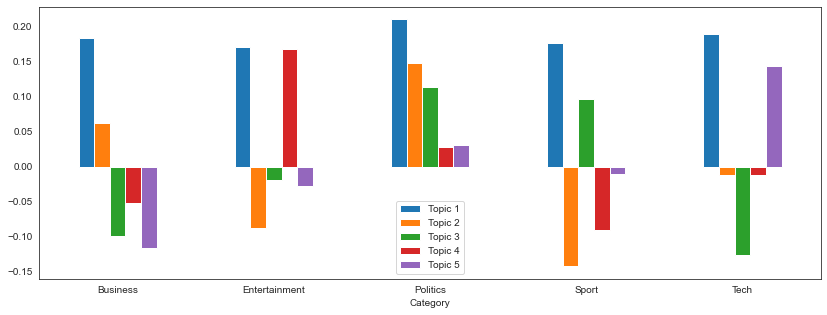

In [28]:
train_result = pd.DataFrame(data=train_doc_topics,
                            columns=topic_labels,
                            index=train_docs.Category)
train_result.groupby(level='Category').mean().plot.bar(figsize=(14, 5), rot=0);

In [31]:
word_count

film          41.256270
government    38.808175
game          36.319726
best          36.093477
uk            36.082515
                ...    
fashion        1.560310
occasion       1.559319
fail           1.558826
typical        1.461780
notice         1.352107
Length: 2917, dtype: float64

In [33]:
svd.components_.T.shape

(2917, 5)

In [30]:
topics = pd.DataFrame(svd.components_.T, index=tokens, columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.096117,-0.157755,-0.037131,0.456760,-0.108419
government,0.105821,0.158542,0.050579,0.000476,-0.032035
game,0.092472,-0.165604,0.074222,-0.112915,0.056594
best,0.088036,-0.148498,0.019054,0.264735,-0.091923
uk,0.092431,0.030233,-0.055868,0.041345,0.012776
labour,0.100164,0.237937,0.227080,0.071624,0.054642
music,0.078805,-0.050253,-0.114264,0.080930,0.140046
000,0.073360,0.029985,-0.044699,0.003032,-0.013678
company,0.067638,0.024084,-0.102071,-0.028465,-0.053378
number,0.070099,-0.039725,-0.019470,0.030363,0.003596


## Most important words by topic
We can also display the words that are most closely associated with each topic (in absolute terms). The topics appear to capture some semantic information but are not clearly differentiated

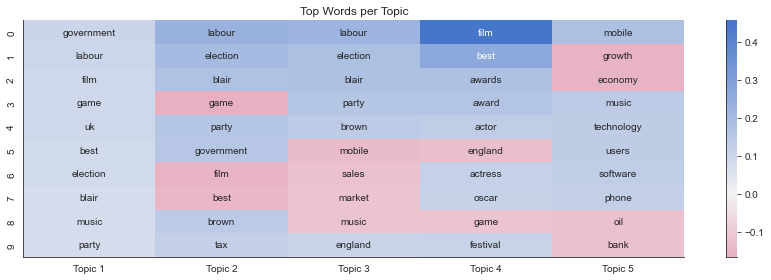

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.abs().nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals),
            annot=top_words,
            fmt='',
            center=0,
            cmap=sns.diverging_palette(0, 255, sep=1, n=256),
            ax=ax)
ax.set_title('Top Words per Topic')
sns.despine()
fig.tight_layout()

## Topics weights for test set
The topic assignments for this sample align with the average topic weights for each category illustrated below (Politics is the leftmost). They illustrate how LSI expresses the k topics as directions in a k-dimensional space (below you find a projection of the average topic assignments per category into two-dimensional space).

Each category is clearly defined, and the test assignments match with train assignments. However, the weights are both positive and negative, making it more difficult to interpret the topics.

In [35]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm),
                         columns=topic_labels,
                         index=test_docs.Category)

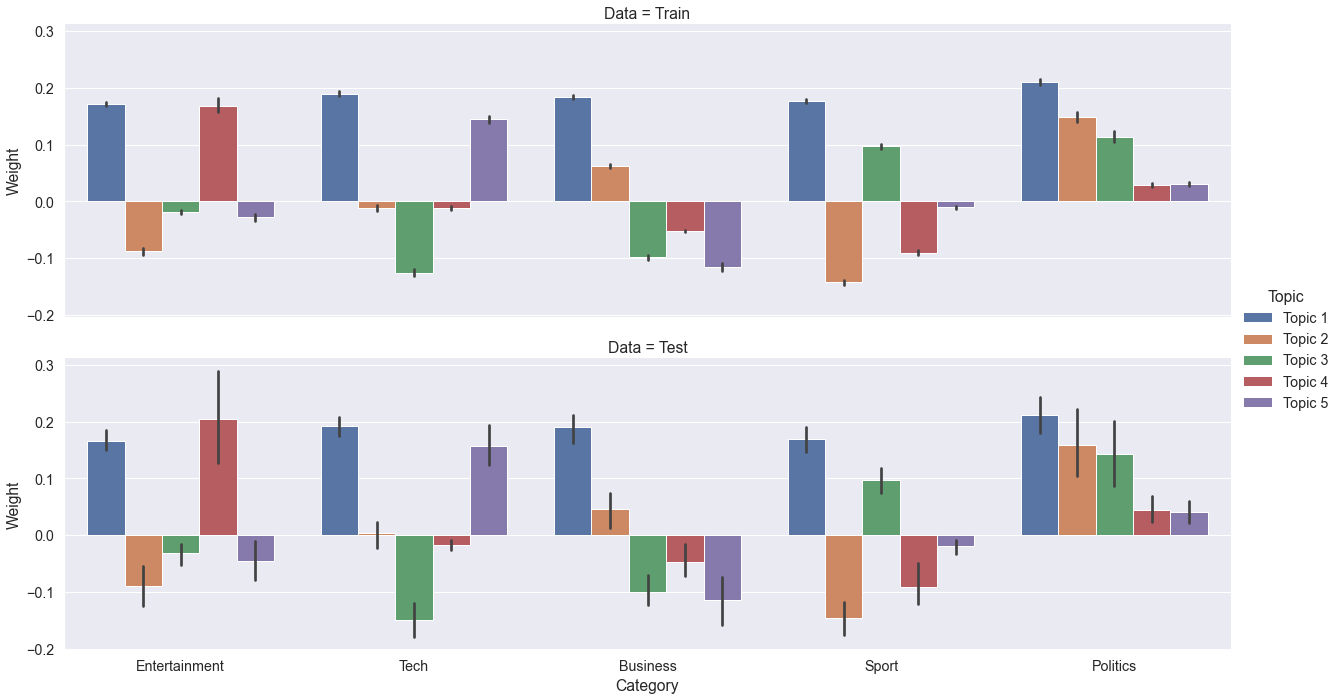

In [36]:
sns.set(font_scale=1.3)
result = pd.melt(train_result.assign(Data='Train').append(
    test_eval.assign(Data='Test')).reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

g = sns.catplot(x='Category',
                y='Weight',
                hue='Topic',
                row='Data',
                kind='bar',
                data=result,
                aspect=3.5);

## Supervised Evaluation
Lets assign each topic to its most prominent counterpart and then solve for classification problem :)

In [46]:
np.argmax(train_doc_topics,axis=1).shape

(2175,)

In [92]:
classes = list(train_docs['Category'].unique())

In [59]:
train_result_pred = train_result.copy()


In [60]:
train_result_pred['pred'] = train_result_pred.apply(lambda x : np.argmax(x)+1,axis=1)
train_result_pred

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,pred
Category,,,,,,
Entertainment,0.139485,-0.072225,-0.010679,0.162038,-0.018796,4
Tech,0.161388,0.035496,-0.099653,-0.027510,0.176396,5
Entertainment,0.138279,-0.065188,0.001179,0.097927,-0.045589,1
Business,0.184543,0.057818,-0.078343,-0.044610,-0.091778,1
Sport,0.170239,-0.115598,0.074803,-0.034476,-0.052675,1
...,...,...,...,...,...,...
Politics,0.298746,0.296472,0.339896,0.086204,0.096711,3
Politics,0.219920,0.132803,0.073142,0.042432,0.040861,1
Sport,0.123865,-0.117063,0.065775,-0.069178,-0.055333,1


In [64]:
train_result_pred.reset_index().groupby(['pred','Category']).count().sort_values('Topic 1',ascending=False)

Topic 1  Topic 2  Topic 3  Topic 4  Topic 5
pred Category                                                  
1    Business           499      499      499      499      499
     Sport              497      497      497      497      497
     Politics           321      321      321      321      321
     Tech               283      283      283      283      283
     Entertainment      230      230      230      230      230
4    Entertainment      147      147      147      147      147
5    Tech               107      107      107      107      107
2    Politics            72       72       72       72       72
3    Politics            13       13       13       13       13
     Sport                2        2        2        2        2
4    Tech                 2        2        2        2        2
5    Politics             2        2        2        2        2

In [69]:
topic_class_mapping = train_result_pred.reset_index().groupby(['pred','Category']).count().sort_values('Topic 1',ascending=False)
topic_class_mapping = topic_class_mapping.reset_index().groupby('pred').agg({'Category':'first'})
topic_class_mapping.columns = ['pred_category']
topic_class_mapping

,pred_category
pred,
1,Business
2,Politics
3,Politics
4,Entertainment
5,Tech


In [72]:
from sklearn.metrics import confusion_matrix


In [93]:
classes

['Entertainment', 'Tech', 'Business', 'Sport', 'Politics']

In [94]:
eval_train_pd = train_result_pred.reset_index().merge(topic_class_mapping.reset_index(),on='pred')
cm = confusion_matrix(eval_train_pd['Category'],eval_train_pd['pred_category'],labels=classes)

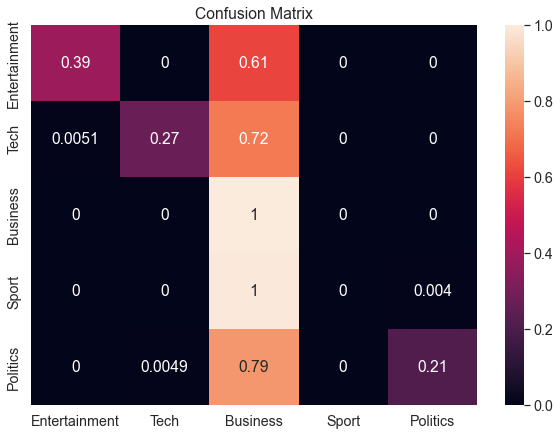

In [116]:

df_cm = pd.DataFrame(cm/cm.sum(axis=1)[:,None], index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
train_result_pred = pd.DataFrame(data=train_result_pred,
                            columns=topic_labels,
                            index=train_docs.Category)
train_result.groupby(level='Category').mean().plot.bar(figsize=(14, 5), rot=0);

## Categories in 2D
The below plot shows the projections of the five topics into a 2D space.



In [117]:
train_result

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Category,,,,,
Entertainment,0.139485,-0.072225,-0.010679,0.162038,-0.018796
Tech,0.161388,0.035496,-0.099653,-0.027510,0.176396
Entertainment,0.138279,-0.065188,0.001179,0.097927,-0.045589
Business,0.184543,0.057818,-0.078343,-0.044610,-0.091778
Sport,0.170239,-0.115598,0.074803,-0.034476,-0.052675
...,...,...,...,...,...
Politics,0.298746,0.296472,0.339896,0.086204,0.096711
Politics,0.219920,0.132803,0.073142,0.042432,0.040861
Sport,0.123865,-0.117063,0.065775,-0.069178,-0.055333


In [38]:
pca = PCA(n_components=2)
svd2d = pd.DataFrame(pca.fit_transform(train_result),
                     columns=['PC1',
                              'PC2']).assign(Category=train_docs.Category)
categories_2d = svd2d.groupby('Category').mean()

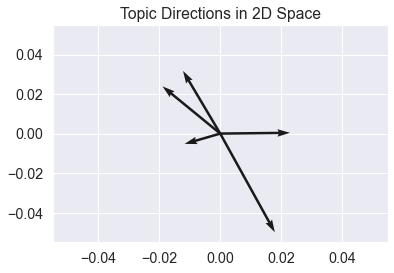

In [39]:
plt.quiver(np.zeros(5),
           np.zeros(5),
           categories_2d.PC1.values,
           categories_2d.PC2.values,
           scale=.035)
plt.title('Topic Directions in 2D Space');

## LDA: Sim

In [118]:
from ipywidgets import interact, FloatSlider


In [120]:
f = FloatSlider(value=1,
                min=1e-2,
                max=10,
                step=1e-2,
                continuous_update=False,
                description='Alpha')

@interact(alpha=f)
def sample_dirichlet(alpha):
    topics = 10
    draws = 9
    alphas = np.full(shape=topics, fill_value=alpha)
    samples = np.random.dirichlet(alpha=alphas, size=draws)

    fig, axes = plt.subplots(nrows=3,
                             ncols=3,
                             sharex=True,
                             sharey=True,
                             figsize=(14, 8))
    axes = axes.flatten()
    plt.setp(axes, ylim=(0, 1))
    for i, sample in enumerate(samples):
        axes[i].bar(x=list(range(10)), height=sample,
                    color=sns.color_palette("Set2", 10))
    fig.suptitle('Dirichlet Allocation | 10 Topics, 9 Samples')
    sns.despine()
    fig.tight_layout()
    plt.subplots_adjust(top=.95)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Alpha', max=10.0, min=0.01,…